<figure>
<IMG SRC="../../lectures/images/PhysicsLogo.jpg" WIDTH=100 ALIGN="right">
</figure>
# [Physics 411](http://jklymak.github.io/Phy411/) Time Series Analysis
*Jody Klymak*


# Assignment 8 
Daniel Scanks
V00788200

### **Q1** Sampling theorem and aliasing

<div style='background:#F0F0F0'>**1** Create a band-limited white noise timeseries with $N=1000$ entries, $dt=0.1 s$, but with all frequencies greater than 0.5 Hz filtered.  Plot the power spectrum to make sure you got it correctly...
</div>

<IPython.core.display.Javascript object>


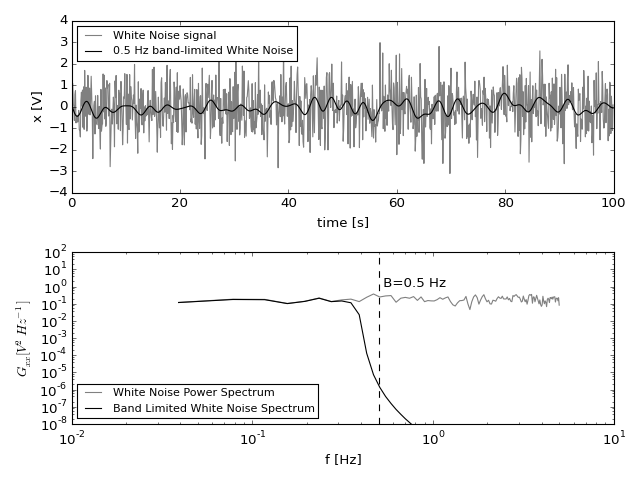

In [40]:
import numpy.random as random
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.signal as signal
%matplotlib nbagg

N = 1000
dt = 0.1
xwn = np.random.randn(N) #white noise
#Bandwidth limit of 0.5Hz
B=0.5
# filter to make Bandlimited signal
fp=B*0.7
fs = B*0.9
fNyq=1/(2.*dt) #nyquist
n,fn=signal.ellipord(fp/fNyq, fs/fNyq,.1, 50.)
b,a=signal.ellip(n,.1,50.,fn)
xbl = signal.filtfilt(b,a,xwn) #bandwidth limited white noise
t = np.arange(0, N*dt, dt)

#power spectrums
Xbl, fbl = mlab.psd(xbl, NFFT = 256, Fs = 1/dt, noverlap =256/2., window = mlab.window_hanning)
Xwn, fwn = mlab.psd(xwn, NFFT = 256, Fs = 1/dt, noverlap = 256/2., window = mlab.window_hanning)


fig,ax=plt.subplots(2,1,figsize=(8,6))
ax[0].plot(t,xwn,color='0.5',label='White Noise signal')
ax[0].plot(t,xbl,color='k',label='0.5 Hz band-limited White Noise')
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel('x [V]')
ax[0].legend(loc=0,fontsize='small')

ax[1].loglog(fwn,Xwn,color='0.5', label = 'White Noise Power Spectrum')
ax[1].loglog(fbl,Xbl,color='k', label = 'Band Limited White Noise Spectrum')
plt.axvline(x=B,linestyle='--',color='k')
ax[1].text(B,1,' B=0.5 Hz')
ax[1].set_ylim([1e-8,1e2])
ax[1].set_xlabel('f [Hz]')
ax[1].set_ylabel('$G_{xx} [V^2 Hz^{-1}]$')
ax[1].legend(loc='lower left',fontsize='small')
plt.tight_layout()


Comment: Can see the filtered spectrum drops off at approximately 0.5Hz, indicating success.


<div style='background:#F0F0F0'>**2** Now decimate by a factor of 4 to get a time series sampled at 2.5 Hz.  Show that you can recover the 10 Hz time series using the Sampling Theorem.</div>

<IPython.core.display.Javascript object>


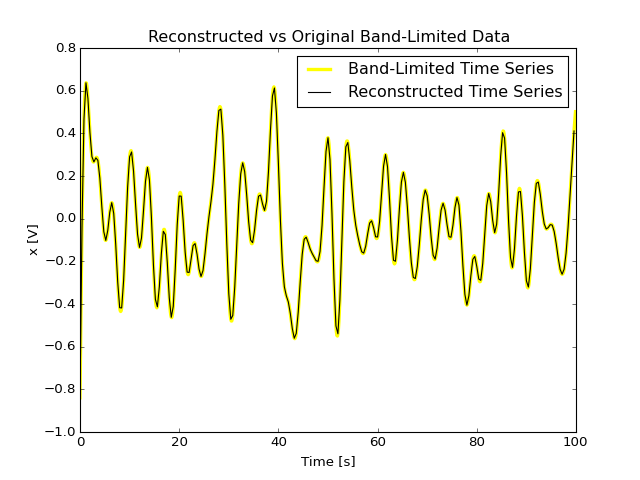

In [18]:
tdec = t[::4] #decimating by factor of 4
fs = 2.5 # newsample frequency
dtnew = 1./fs
xdec = xbl[::4] #decimating by factor of 4

#recovering 
xrecovered = np.zeros(N/4)
n = np.arange(N/4.)
for i in range(N/4):
    xrecovered[i] = np.sum(xdec*np.sinc(fs*tdec[i] - n))  

fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(t, xbl, linewidth = 3.0, color = 'yellow', label = 'Band-Limited Time Series ')
ax.plot(tdec,xrecovered, linewidth = 1.0, color = 'black', label='Reconstructed Time Series')
ax.set_xlabel('Time [s]')
ax.set_ylabel('x [V]')
ax.set_title('Reconstructed vs Original Band-Limited Data')
ax.legend()
    


Comments:
As seen on the graph, the recovered time series matches up perfectly with the origional band limited time series. This means that with a decimation factor of 4, there is still enough data to reconstruct the series.

<div style='background:#F0F0F0'>**3** Now decimate by a factor of 40 to get a time series sampled at 0.25 Hz.  Show that you cannot recover the 10 Hz time series using the Sampling Theorem.</div>

<IPython.core.display.Javascript object>


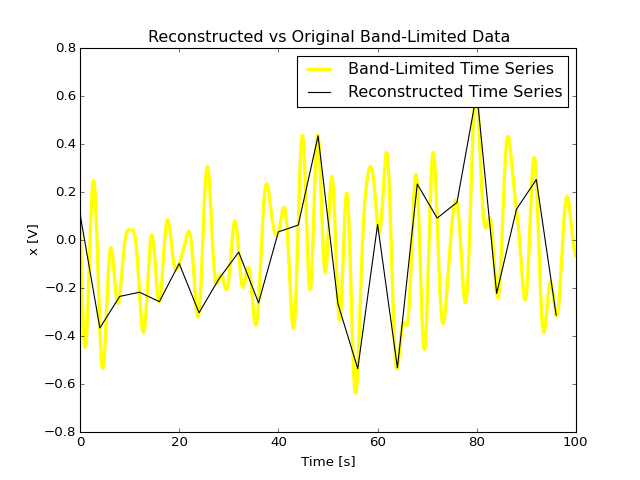

In [41]:
tdec = t[::40] #decimating by factor of 40
fs = 0.25 # newsample frequency
dtnew = 1./fs
xdec = xbl[::40] #decimating by factor of 40

#recovering 
xrecovered = np.zeros(N/40)
n = np.arange(N/40.)
for i in range(N/40):
    xrecovered[i] = np.sum(xdec*np.sinc(fs*tdec[i] - n))  

fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(t, xbl, linewidth = 3.0, color = 'yellow', label = 'Band-Limited Time Series ')
ax.plot(tdec,xrecovered, linewidth = 1.0, color = 'black', label='Reconstructed Time Series')
ax.set_xlabel('Time [s]')
ax.set_ylabel('x [V]')
ax.set_title('Reconstructed vs Original Band-Limited Data')
ax.legend()

Comments:
Decimation by a factor of 40 simply removes too much data for there to be an accurate reconstruction of the original time series using the sampling theorem. This is because the nyquist frequency is below the bandwidth limiting frequency, and therefore much of the data below 0.5 Hz is not well resolved. If the nyquist f was higher than the bandwidth limit, then all non filtered data would be well resolved (e.g 4x decimation).

## Q2: Cubic Spline

Using the data below...

In [21]:
t = np.array([0.,2.5,2.7,3.4,4.2,6.5,9.0])
x= np.cos(t*2*np.pi/3)


**1** Perform a cubic spline interpolation onto an even grid from 0 to 9.0 by 
  
  1. creating the matrix from the notes
  2. inverting and solving for the cubic co-efficients
  3. using those polynomials to evaluate the interpolated data.

Compare with using `scipy.interpolate.interp1d`.
Comment on any similarities or differences between the two results.

In [27]:
#1) Create Matrix (N+1)x(N+1)
N = 6
delta = np.diff(t) # delta's between times (t(0)-t(1),t(1)-t(2), ect)
print len(delta)
matrix = np.matrix([[1, 0, 0, 0, 0, 0, 0],[delta[0],(2*(delta[0]+delta[1])), delta[1], 0, 0, 0, 0],
                    [0,delta[1],(2*(delta[1]+delta[2])), delta[2], 0, 0, 0],
                    [0, 0, delta[2],(2*(delta[2]+delta[3])), delta[3], 0, 0],
                    [0, 0, 0, delta[3],(2*(delta[3]+delta[4])), delta[4], 0],
                    [0, 0, 0, 0, delta[4],(2*(delta[4]+delta[5])), delta[5]],[0, 0, 0, 0, 0, 0, 1]])


deltax = np.diff(x)
xmatrix = np.matrix([[0],[(deltax[1]/delta[1]) - (deltax[0]/delta[0])],[(deltax[2]/delta[2]) - (deltax[1]/delta[1])],
                    [(deltax[3]/delta[3]) - (deltax[2]/delta[2])], [(deltax[4]/delta[4]) - (deltax[3]/delta[3])], 
                    [(deltax[5]/delta[5]) - (deltax[4]/delta[4])], [0]])
xmatrix = 3*xmatrix
print xmatrix


6
[[ 0.        ]
 [ 5.23525492]
 [-5.23476801]
 [-4.94354041]
 [ 7.25046697]
 [-1.10741347]
 [ 0.        ]]


In [29]:
#2)inverting and solving for cubic coeff
ci = np.linalg.solve(matrix, xmatrix) #inversion implied when solving the matgrix eqn
ai = 1.*x   # defining the a values
di = np.zeros(N)
di[5] = -2*ci[5]/(6*delta[5])
for i in range(5):
    di[i] = (2*ci[i+1]-2*ci[i])/(6*delta[i])

bi = np.zeros(N)
for i in range(N):
    bi[i] = (ai[i+1]-ai[i]-ci[i]*(delta[i]**2)-(delta[i]**3)*di[i])/delta[i]   




<IPython.core.display.Javascript object>


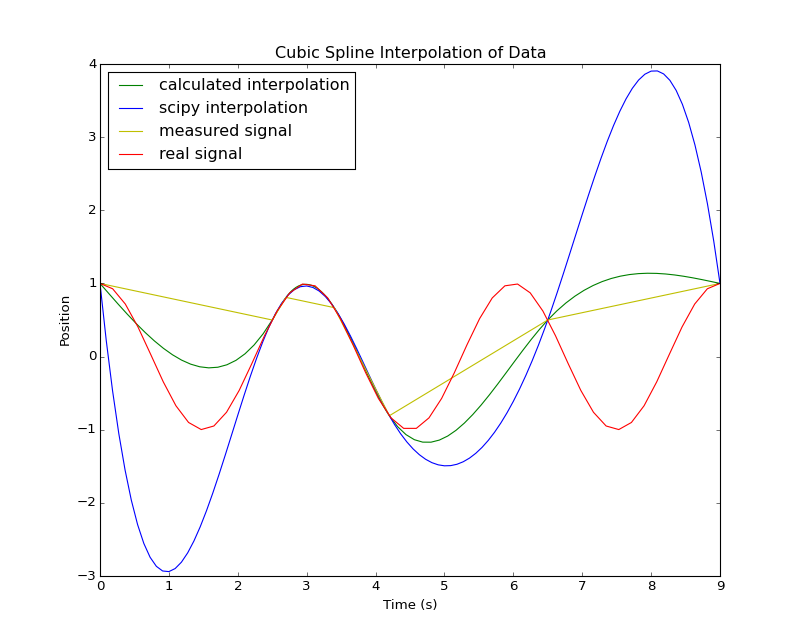

In [39]:
from scipy.interpolate import interp1d

#3) using polynomials to evaluate data
qi = np.array([x[0]])   # full new signal
toverall = np.array([0])   #define the total time vetor for the interpolation
for i in range(6):           
    tfit = np.linspace(t[i],t[i+1], 20)
    toverall = np.concatenate((toverall,tfit[1:]), axis = 1)  #add this time range to the previous time range
    fit = np.zeros(len(tfit))
    for j in range(len(tfit)):
        fit[j] = x[i]+ bi[i]*(tfit[j]-t[i])+ci[i]*((tfit[j]-t[i])**2)+di[i]*((tfit[j]-t[i])**3)
    
    qi = np.concatenate((qi,fit[1:]), axis = 1)
    qi[-1] = x[i+1]   #fixing the point at this time to the real measured value

#define the real signal that the values were sampled from
treal = np.linspace(0,9)
xreal= np.cos(treal*2*np.pi/3)

#via scripy
int_fc = interp1d(t,x,kind = 'cubic')
tcu = np.linspace(0,9,100)
xcu = int_fc(tcu)

#plot


fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(toverall, qi, 'g', label = 'calculated interpolation')
ax.plot(tcu, xcu, label = 'scipy interpolation')
ax.plot(t,x, 'y', label = 'measured signal')
ax.plot(treal,xreal,'r', label = 'real signal')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Position')
ax.set_title('Cubic Spline Interpolation of Data ')
ax.legend(loc = 'upper left')


Comments:
scripy vs cubic spline: the cubic spline approximated the real data best, but the scripy interpolate function did somewhat match the curves of the plot. They both match up very well between ~2-5s and begin to deviate strongly around 6s+. 